[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%2010%20-%20Metric%20Learning/P10_Metric_Learning.ipynb)

# Metric Learning

In this practical, we will calculate 2-dimensional embeddings (so that we can easily visualise them) using different approaches: a classification network, a siamese network, and a triplet network. We will use FashionMNIST.

First some preliminary stuff. Apart from typical imports, we define also two functions that will help us later on to generate embeddings for all our data and to plot them in a 2D scatter plot.

In [ ]:
import os
import random

import torch
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

## Import data

Import the FashionMNIST data and define datasets and data loaders.

In [ ]:
mean, std = 0.28604059698879553, 0.35302424451492237

train_dataset = FashionMNIST('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

100%|██████████| 26421880/26421880 [00:03<00:00, 7880775.58it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 143246.96it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2600825.32it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21788372.34it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

In [ ]:
# Set up data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## The Embedding Network

To do the embedding always in the same manner, we will define the embedding part once, and then reuse it with different networks. The embedding we will use is a small CNN architecture, followed by a couple of FC layers that bring down the output to 2 dimensions (so that we can plot the results later).

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

## Classification Head

The first embedding we will learn is by using a classification head. We define our classification model to use our standard embedding to 2 dimensions, then bring it up to the number of classes (10 in the case if FashionMNIST) and return the logits. We then train it using `torch.nn.CrossEntropyLoss()`.

In [ ]:
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        return self.fc1(output)

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [ ]:
def train_epoch(train_loader, model, criterion, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(device)
        data = data.to(device)

        optimizer.zero_grad()

        outputs = model(data)

        loss = criterion(outputs, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Evaluate on training set
        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % 20 == 0:
            print("Iteration {}: Loss = {}".format(batch_idx, loss.item()))

    total_loss /= (batch_idx + 1)
    accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, accuracy

@torch.no_grad()
def test_epoch(val_loader, model, criterion):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        target = target.to(device)
        data = data.to(device)

        outputs = model(data)

        loss = criterion(outputs, target)
        val_loss += loss.item()

        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [ ]:
embedding_net = EmbeddingNet().to(device)

n_classes = 10
model = ClassificationNet(embedding_net, n_classes=n_classes)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

In [ ]:
n_epochs = 10 # Do 10 epochs
for epoch in range(n_epochs):

    # Train stage
    train_loss, acc = train_epoch(train_loader, model, criterion, optimizer)

    scheduler.step()
    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, train_loss, acc)

    # Validation stage
    val_loss, acc = test_epoch(test_loader, model, criterion)
    val_loss /= len(test_loader)

    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, val_loss, acc)

    print(message)

Iteration 0: Loss = 2.4081709384918213
Iteration 20: Loss = 1.818416953086853
Iteration 40: Loss = 1.626611351966858
Iteration 60: Loss = 1.3835968971252441
Iteration 80: Loss = 1.276626706123352
Iteration 100: Loss = 1.1306180953979492
Iteration 120: Loss = 1.0320237874984741
Iteration 140: Loss = 1.1091424226760864
Iteration 160: Loss = 0.9483420848846436
Iteration 180: Loss = 0.8767510652542114
Iteration 200: Loss = 0.7164555788040161
Iteration 220: Loss = 0.8003494143486023
Epoch: 1/10. Train set: Average loss: 1.2186 Accuracy: 53.13
Epoch: 1/10. Validation set: Average loss: 0.8036 Accuracy: 71.41
Iteration 0: Loss = 0.7110498547554016
Iteration 20: Loss = 0.7264464497566223
Iteration 40: Loss = 0.5864696502685547
Iteration 60: Loss = 0.5000516772270203
Iteration 80: Loss = 0.6158287525177002
Iteration 100: Loss = 0.6071817874908447
Iteration 120: Loss = 0.607359766960144
Iteration 140: Loss = 0.5988886952400208
Iteration 160: Loss = 0.6357583403587341
Iteration 180: Loss = 0.6983

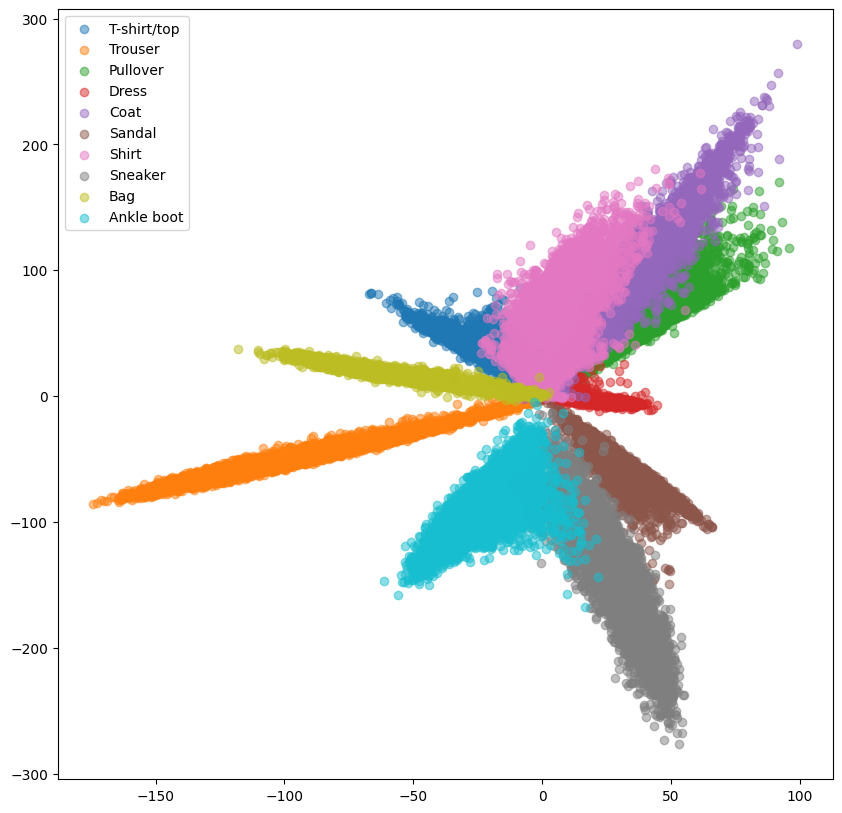

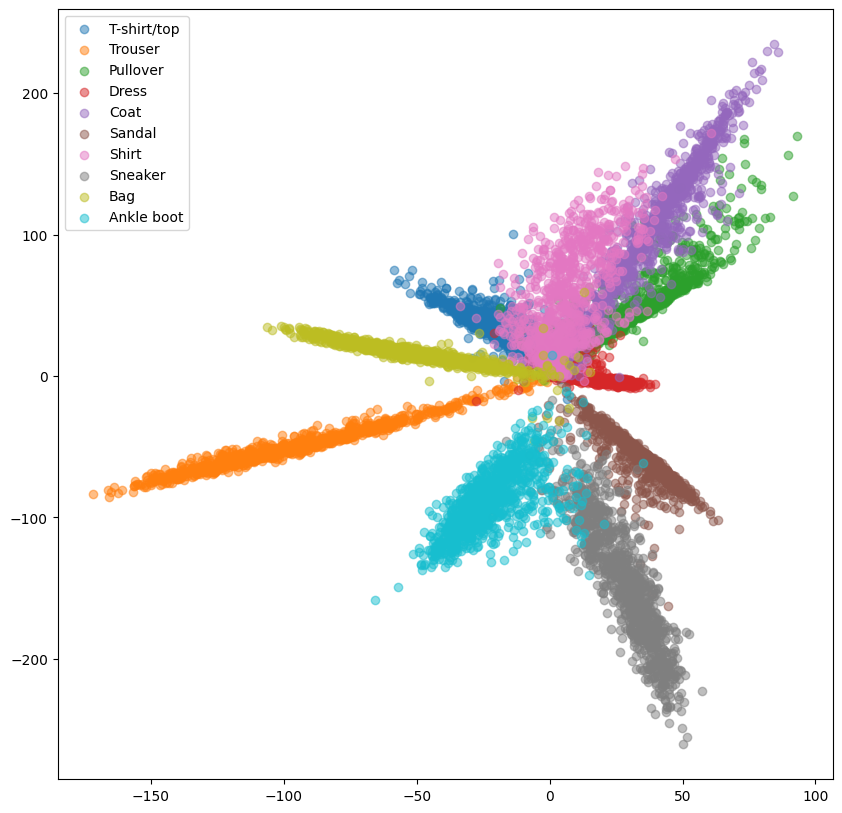

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Siamese Head

We will repeat the process with a siamese network, but in order to do that we need first to create a different dataset, that creates positive and negative pairs from the original dataset. The pairs will be generated on the fly, randomly, while training. While testing, we will maintain the same pairs always so that comparisons would make sense.

Note that here we just aim to create valid pairs, we do not do any mining (we do not care if they are easy, semi-hard or hard).

In [ ]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        self.labels = self.mnist_dataset.targets
        self.data = self.mnist_dataset.data
        self.labels_set = set(self.labels.numpy())
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}

        if not self.train:
            # generate fixed pairs for testing once at initialisation
            random_state = np.random.RandomState(29) # Fix random seed for testing

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.labels[i].item()]),#get a random lable of the same type as positive label
                               1]
                              for i in range(0, len(self.data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.labels[i].item()]))#subtract all the positive labels of the datset and choose a radom sample, that must be negative
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            # Generate a positive or negative pair on the fly
            target = np.random.randint(0, 2) # randomly select positive or negative
            img1, label1 = self.data[index], self.labels[index].item()
            if target == 1: # Generate a POSITIVE pair
                siamese_index = index
                while siamese_index == index: # Make sure we do not use ourself as the positive pair
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else: # Generate a NEGATIVE pair
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.data[siamese_index]
        else:
            # Just retrieve the pair from the saved test pairs we generated at init
            img1 = self.data[self.test_pairs[index][0]]
            img2 = self.data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        # Get a PIL image to pass through transform
        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, target


    def __len__(self):
        return len(self.mnist_dataset)

Now we are ready to define our siamese net which just takes in one training sample (which now comprises a pair of images) and embeds them using our embedding function. It returns the two embeddings.

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

The next thing to do is to define our loss function for the case of the siamese. In this case, we need a function that takes as input TWO vectors and one target that indicates if they are supposed to be a positive pair, or a negative pair, and implements the function:

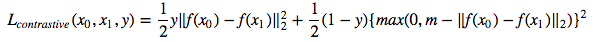

In [ ]:
class ContrastiveLoss(nn.Module):
    """
    Max-Margin Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        # losses = 0.5 * (target.float() * distances + (1 - target).float() * max(0, self.margin - (distances + self.eps).sqrt()).pow(2)) equivalent to
        losses = 0.5 * (target.float() * distances + (1 - target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

We will also redefine the training and validation loops, as now the data loader gives us 2 samples and the loss function expects 2 samples.

In [ ]:
def train_epoch_siamese(train_loader, model, criterion, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(train_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        optimizer.zero_grad()

        output1, output2 = model(data1, data2)

        # The loss is the only thing we can report here
        loss = criterion(output1, output2, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print("Iteration {}: Loss = {}".format(batch_idx, loss.item()))

    total_loss /= (batch_idx + 1)
    return total_loss

@torch.no_grad()
def test_epoch_siamese(val_loader, model, criterion):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(val_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        output1, output2 = model(data1, data2)

        loss = criterion(output1, output2, target)
        val_loss += loss.item()

    return val_loss

In [ ]:
siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(test_dataset)   # Note that the train datasets has self.train == True, and the test has self.train == False

batch_size = 256
siamese_train_loader = DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)
siamese_test_loader = DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False)

margin = 1.

embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
model.to(device)

criterion = ContrastiveLoss(margin)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

In [ ]:
n_epochs = 10 # Do 10 epochs
for epoch in range(n_epochs):

        # Train stage
        train_loss = train_epoch_siamese(siamese_train_loader, model, criterion, optimizer)
        scheduler.step()

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)

        # Validation stage
        val_loss = test_epoch_siamese(siamese_test_loader, model, criterion)
        val_loss /= len(siamese_test_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, val_loss)

        print(message)

Iteration 0: Loss = 0.20643338561058044
Iteration 20: Loss = 0.06461012363433838
Iteration 40: Loss = 0.054381877183914185
Iteration 60: Loss = 0.056785229593515396
Iteration 80: Loss = 0.049561887979507446
Iteration 100: Loss = 0.05157185718417168
Iteration 120: Loss = 0.057282060384750366
Iteration 140: Loss = 0.04842910170555115
Iteration 160: Loss = 0.05200984328985214
Iteration 180: Loss = 0.05106484889984131
Iteration 200: Loss = 0.04329102113842964
Iteration 220: Loss = 0.04608052223920822
Epoch: 1/10. Train set: Average loss: 0.0526
Epoch: 1/10. Validation set: Average loss: 0.0430
Iteration 0: Loss = 0.047616466879844666
Iteration 20: Loss = 0.04240981489419937
Iteration 40: Loss = 0.03845324367284775
Iteration 60: Loss = 0.033481940627098083
Iteration 80: Loss = 0.04143209755420685
Iteration 100: Loss = 0.05131455883383751
Iteration 120: Loss = 0.036266714334487915
Iteration 140: Loss = 0.04251911863684654
Iteration 160: Loss = 0.036537427455186844
Iteration 180: Loss = 0.041

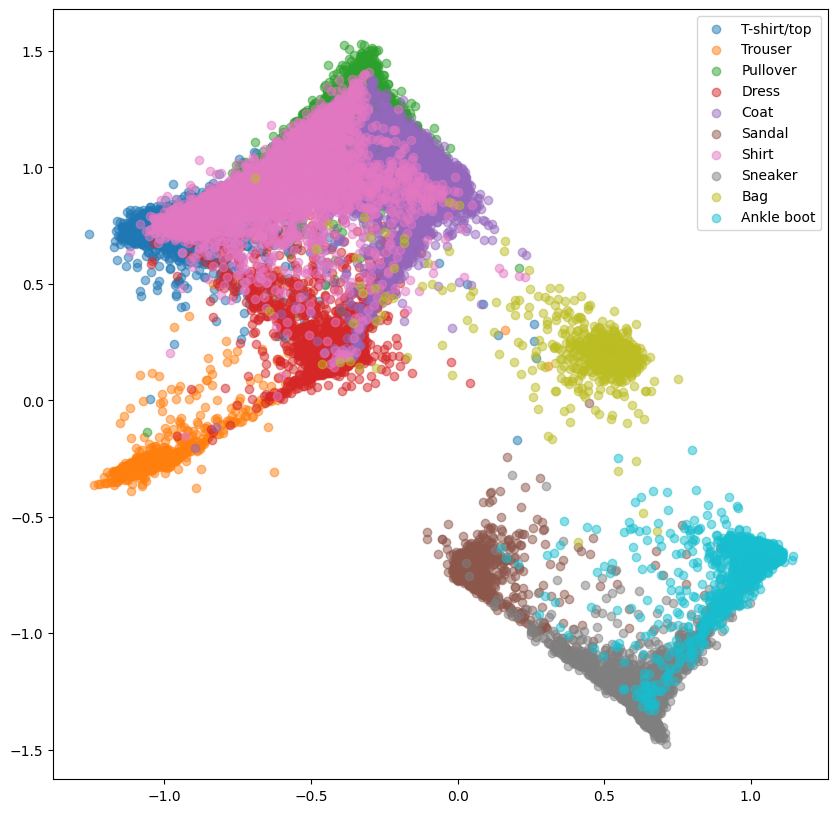

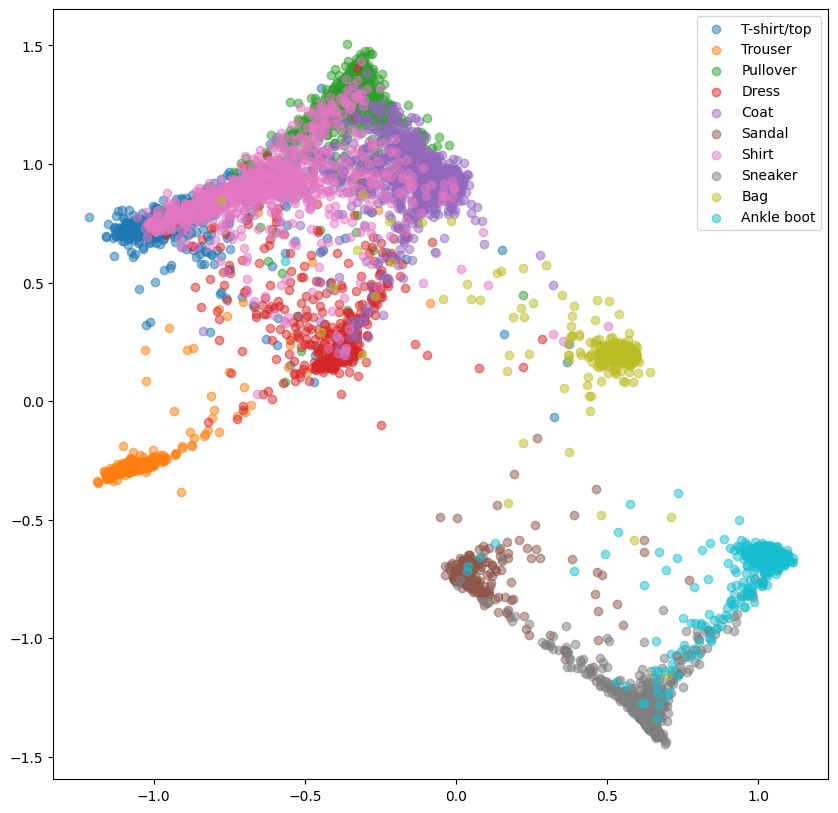

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

There are couple of problems with siamese and (triplet) networks the way we have implemented them up to this point.

- The number of possible pairs/triplets grows quadratically/cubically with the number of examples. It's infeasible to process them all
- We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with hard examples.
- Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In this case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

## Triplet Loss

We will now train FashionMNIST using a semi-hard Triplet Mining strategy, and visualize the embeddings.

We will not implement any miner, loss or distance function by hand. Instead we will use [The Pytorch Metric Learning Library](https://github.com/KevinMusgrave/pytorch-metric-learning) (installed in the cell below) which implements everything we need.

Check its [docs](https://kevinmusgrave.github.io/pytorch-metric-learning/) so that you get an idea of how to use it.

Install the required packages below. Uncomment the corresponding cell to use the package manager that suits your installation (for Google Colab, that would be pip).

In [ ]:
#%conda install -y -c metric-learning pytorch-metric-learning=2.1.1
#%conda install -y -c conda-forge faiss-gpu=1.6.5

In [ ]:
%pip install pytorch-metric-learning faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.0 MB/s eta 0:00:00


In [ ]:
from pytorch_metric_learning import losses, miners, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

We will redefine our training and test loops to use this library. The idea is that first we embedd all the data inside our batch. Then we will ask a *Miner* to find good triplets. The list of triplets (a list of tuples with indices) will be passed on to the loss function, that will calculate the loss based on them.

In [ ]:
def train(model, loss_func, mining_func, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        embeddings = model(data)

        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)

        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

    return total_loss / (batch_idx + 1)

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester(dataloader_num_workers=2)
    return tester.get_all_embeddings(dataset, model)

def test(train_set, test_set, model, accuracy_calculator):
    model.eval()
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)

    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(query = train_embeddings, reference = test_embeddings, query_labels = train_labels, reference_labels = test_labels)

    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


We now need to define our miner. Here we will use a `TripletMarginMiner` and cosine similarity to measure the distance between embeddings. We will also use an "accuracy" calculator. The actual metric we will be using is a *precision at 1*, which is just a fancy way to ask whether the 1st nearest neighbour of each sample is of the same class.

https://kevinmusgrave.github.io/pytorch-metric-learning/accuracy_calculation/

In [ ]:
distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="all")
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

Define the datasets, dataloaders, and the model to use. The model we will use here is just the embedding net on its own.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = EmbeddingNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = losses.TripletMarginLoss(margin=1., distance = distance)

Epoch 1 Iteration 0: Loss = 1.401984453201294, Number of mined triplets = 714751
Epoch 1 Iteration 20: Loss = 0.9974822998046875, Number of mined triplets = 815958
Epoch 1 Iteration 40: Loss = 1.0057072639465332, Number of mined triplets = 618203
Epoch 1 Iteration 60: Loss = 0.9927799701690674, Number of mined triplets = 596729
Epoch 1 Iteration 80: Loss = 0.9722110629081726, Number of mined triplets = 574156
Epoch 1 Iteration 100: Loss = 0.9843627214431763, Number of mined triplets = 517642
Epoch 1 Iteration 120: Loss = 1.0092487335205078, Number of mined triplets = 522163
Epoch 1 Iteration 140: Loss = 1.005739450454712, Number of mined triplets = 415332
Epoch 1 Iteration 160: Loss = 0.9753066897392273, Number of mined triplets = 425168
Epoch 1 Iteration 180: Loss = 0.9949727654457092, Number of mined triplets = 633723
Epoch 1 Iteration 200: Loss = 0.9920262098312378, Number of mined triplets = 336391
Epoch 1 Iteration 220: Loss = 0.967553436756134, Number of mined triplets = 384737


100%|██████████| 313/313 [00:03<00:00, 82.65it/s]


Computing accuracy


/usr/local/lib/python3.10/dist-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)
/usr/local/lib/python3.10/dist-packages/faiss/contrib/torch_utils.py:65: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 8)


Test set accuracy (Precision@1) = 0.5761666666666667
Epoch 2 Iteration 0: Loss = 0.9776037931442261, Number of mined triplets = 369737
Epoch 2 Iteration 20: Loss = 0.9984763264656067, Number of mined triplets = 402434
Epoch 2 Iteration 40: Loss = 0.9957565069198608, Number of mined triplets = 279979
Epoch 2 Iteration 60: Loss = 0.9978191256523132, Number of mined triplets = 374704
Epoch 2 Iteration 80: Loss = 1.0001355409622192, Number of mined triplets = 554476
Epoch 2 Iteration 100: Loss = 0.9716775417327881, Number of mined triplets = 518616
Epoch 2 Iteration 120: Loss = 0.9745597839355469, Number of mined triplets = 445546
Epoch 2 Iteration 140: Loss = 0.9904439449310303, Number of mined triplets = 354551
Epoch 2 Iteration 160: Loss = 1.014623761177063, Number of mined triplets = 332623
Epoch 2 Iteration 180: Loss = 0.9910127520561218, Number of mined triplets = 400172
Epoch 2 Iteration 200: Loss = 0.971933126449585, Number of mined triplets = 351533
Epoch 2 Iteration 220: Loss = 1

100%|██████████| 313/313 [00:03<00:00, 84.16it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6479833333333334
Epoch 3 Iteration 0: Loss = 0.9896514415740967, Number of mined triplets = 267206
Epoch 3 Iteration 20: Loss = 1.0159976482391357, Number of mined triplets = 306766
Epoch 3 Iteration 40: Loss = 0.9696328639984131, Number of mined triplets = 492015
Epoch 3 Iteration 60: Loss = 1.021783709526062, Number of mined triplets = 223505
Epoch 3 Iteration 80: Loss = 1.0104825496673584, Number of mined triplets = 319562
Epoch 3 Iteration 100: Loss = 1.0121004581451416, Number of mined triplets = 334324
Epoch 3 Iteration 120: Loss = 0.9795475602149963, Number of mined triplets = 239512
Epoch 3 Iteration 140: Loss = 0.9971138834953308, Number of mined triplets = 247384
Epoch 3 Iteration 160: Loss = 1.051039457321167, Number of mined triplets = 330197
Epoch 3 Iteration 180: Loss = 0.9997180104255676, Number of mined triplets = 233003
Epoch 3 Iteration 200: Loss = 0.9639201164245605, Number of mined triplets = 311209
Epoch 3 Iter

100%|██████████| 313/313 [00:03<00:00, 81.09it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.6939333333333334
Epoch 4 Iteration 0: Loss = 1.0171228647232056, Number of mined triplets = 247337
Epoch 4 Iteration 20: Loss = 0.9886366128921509, Number of mined triplets = 250295
Epoch 4 Iteration 40: Loss = 1.025280475616455, Number of mined triplets = 260859
Epoch 4 Iteration 60: Loss = 0.9658299684524536, Number of mined triplets = 245455
Epoch 4 Iteration 80: Loss = 0.9607961773872375, Number of mined triplets = 262974
Epoch 4 Iteration 100: Loss = 0.966558575630188, Number of mined triplets = 251982
Epoch 4 Iteration 120: Loss = 1.0155785083770752, Number of mined triplets = 217674
Epoch 4 Iteration 140: Loss = 1.0060962438583374, Number of mined triplets = 248828
Epoch 4 Iteration 160: Loss = 0.9831023216247559, Number of mined triplets = 261475
Epoch 4 Iteration 180: Loss = 0.9610872864723206, Number of mined triplets = 181169
Epoch 4 Iteration 200: Loss = 0.9679602384567261, Number of mined triplets = 225841
Epoch 4 Iter

100%|██████████| 313/313 [00:03<00:00, 80.35it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7112
Epoch 5 Iteration 0: Loss = 0.9751486778259277, Number of mined triplets = 240821
Epoch 5 Iteration 20: Loss = 1.0125068426132202, Number of mined triplets = 224635
Epoch 5 Iteration 40: Loss = 0.9743922352790833, Number of mined triplets = 232509
Epoch 5 Iteration 60: Loss = 0.9925172328948975, Number of mined triplets = 214418
Epoch 5 Iteration 80: Loss = 0.975112795829773, Number of mined triplets = 203378
Epoch 5 Iteration 100: Loss = 0.9901340007781982, Number of mined triplets = 205849
Epoch 5 Iteration 120: Loss = 0.9832667112350464, Number of mined triplets = 294928
Epoch 5 Iteration 140: Loss = 1.0664126873016357, Number of mined triplets = 235703
Epoch 5 Iteration 160: Loss = 0.9860698580741882, Number of mined triplets = 222639
Epoch 5 Iteration 180: Loss = 0.9795980453491211, Number of mined triplets = 280931
Epoch 5 Iteration 200: Loss = 1.0205286741256714, Number of mined triplets = 221984
Epoch 5 Iteration 220: 

100%|██████████| 313/313 [00:03<00:00, 79.07it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.7374
Epoch 6 Iteration 0: Loss = 0.9735577702522278, Number of mined triplets = 241745
Epoch 6 Iteration 20: Loss = 0.9900565147399902, Number of mined triplets = 241410
Epoch 6 Iteration 40: Loss = 0.9678709506988525, Number of mined triplets = 214753
Epoch 6 Iteration 60: Loss = 0.9898223280906677, Number of mined triplets = 201368
Epoch 6 Iteration 80: Loss = 0.9990456700325012, Number of mined triplets = 260010
Epoch 6 Iteration 100: Loss = 0.9587305784225464, Number of mined triplets = 174049
Epoch 6 Iteration 120: Loss = 0.9667903780937195, Number of mined triplets = 224324
Epoch 6 Iteration 140: Loss = 1.0119496583938599, Number of mined triplets = 217850
Epoch 6 Iteration 160: Loss = 1.0250135660171509, Number of mined triplets = 260043
Epoch 6 Iteration 180: Loss = 1.000138521194458, Number of mined triplets = 240706
Epoch 6 Iteration 200: Loss = 1.0058585405349731, Number of mined triplets = 279966
Epoch 6 Iteration 220: 

100%|██████████| 313/313 [00:04<00:00, 76.57it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.7385666666666667
Epoch 7 Iteration 0: Loss = 0.9844843745231628, Number of mined triplets = 212723
Epoch 7 Iteration 20: Loss = 0.9722865223884583, Number of mined triplets = 275623
Epoch 7 Iteration 40: Loss = 1.043010950088501, Number of mined triplets = 209209
Epoch 7 Iteration 60: Loss = 1.0088825225830078, Number of mined triplets = 242454
Epoch 7 Iteration 80: Loss = 0.9561368227005005, Number of mined triplets = 219480
Epoch 7 Iteration 100: Loss = 1.0076560974121094, Number of mined triplets = 212895
Epoch 7 Iteration 120: Loss = 1.0412158966064453, Number of mined triplets = 165799
Epoch 7 Iteration 140: Loss = 1.029272437095642, Number of mined triplets = 195204
Epoch 7 Iteration 160: Loss = 0.9385594129562378, Number of mined triplets = 197163
Epoch 7 Iteration 180: Loss = 0.9787325859069824, Number of mined triplets = 298992
Epoch 7 Iteration 200: Loss = 0.9956226348876953, Number of mined triplets = 206574
Epoch 7 Iter

100%|██████████| 313/313 [00:03<00:00, 83.03it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.7640666666666667
Epoch 8 Iteration 0: Loss = 0.9420996904373169, Number of mined triplets = 185393
Epoch 8 Iteration 20: Loss = 1.0169800519943237, Number of mined triplets = 168828
Epoch 8 Iteration 40: Loss = 0.9816849231719971, Number of mined triplets = 224554
Epoch 8 Iteration 60: Loss = 0.9746692180633545, Number of mined triplets = 267751
Epoch 8 Iteration 80: Loss = 0.9893969297409058, Number of mined triplets = 182428
Epoch 8 Iteration 100: Loss = 0.9741016030311584, Number of mined triplets = 270094
Epoch 8 Iteration 120: Loss = 0.9819979667663574, Number of mined triplets = 191252
Epoch 8 Iteration 140: Loss = 0.9799638390541077, Number of mined triplets = 185994
Epoch 8 Iteration 160: Loss = 0.9669909477233887, Number of mined triplets = 226822
Epoch 8 Iteration 180: Loss = 1.000199317932129, Number of mined triplets = 151133
Epoch 8 Iteration 200: Loss = 1.0108916759490967, Number of mined triplets = 156941
Epoch 8 Ite

100%|██████████| 313/313 [00:03<00:00, 83.39it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.77725
Epoch 9 Iteration 0: Loss = 0.9793148636817932, Number of mined triplets = 185670
Epoch 9 Iteration 20: Loss = 0.9762610197067261, Number of mined triplets = 171430
Epoch 9 Iteration 40: Loss = 0.9795660376548767, Number of mined triplets = 161363
Epoch 9 Iteration 60: Loss = 1.0301066637039185, Number of mined triplets = 219638
Epoch 9 Iteration 80: Loss = 1.0012415647506714, Number of mined triplets = 229310
Epoch 9 Iteration 100: Loss = 0.9870893955230713, Number of mined triplets = 225105
Epoch 9 Iteration 120: Loss = 0.9855173230171204, Number of mined triplets = 216046
Epoch 9 Iteration 140: Loss = 0.9952580332756042, Number of mined triplets = 161744
Epoch 9 Iteration 160: Loss = 0.9718973636627197, Number of mined triplets = 280869
Epoch 9 Iteration 180: Loss = 0.9857020974159241, Number of mined triplets = 191102
Epoch 9 Iteration 200: Loss = 1.0046250820159912, Number of mined triplets = 160638
Epoch 9 Iteration 220

100%|██████████| 313/313 [00:03<00:00, 85.20it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.7736666666666667
Epoch 10 Iteration 0: Loss = 0.9900842308998108, Number of mined triplets = 209566
Epoch 10 Iteration 20: Loss = 0.9554893970489502, Number of mined triplets = 210606
Epoch 10 Iteration 40: Loss = 0.9805632829666138, Number of mined triplets = 203662
Epoch 10 Iteration 60: Loss = 1.0130060911178589, Number of mined triplets = 246164
Epoch 10 Iteration 80: Loss = 0.9740133881568909, Number of mined triplets = 188644
Epoch 10 Iteration 100: Loss = 1.0269454717636108, Number of mined triplets = 239645
Epoch 10 Iteration 120: Loss = 0.982251763343811, Number of mined triplets = 212865
Epoch 10 Iteration 140: Loss = 0.9910721182823181, Number of mined triplets = 185525
Epoch 10 Iteration 160: Loss = 0.9735783934593201, Number of mined triplets = 156962
Epoch 10 Iteration 180: Loss = 0.9747862815856934, Number of mined triplets = 202390
Epoch 10 Iteration 200: Loss = 0.9786353707313538, Number of mined triplets = 157365


100%|██████████| 313/313 [00:03<00:00, 84.56it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.7921333333333334


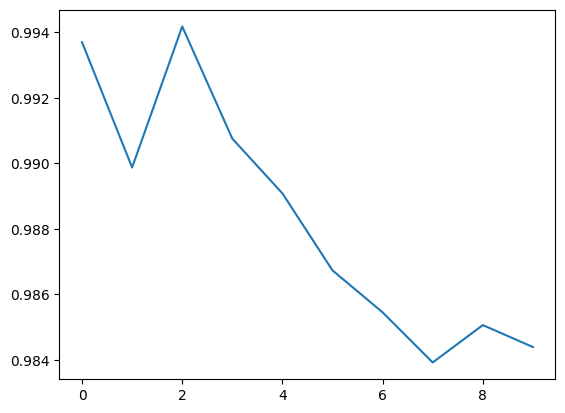

In [ ]:
num_epochs = 10
loss_evolution = []

for epoch in range(1, num_epochs + 1):
    loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution.append(loss)
    test(train_dataset, test_dataset, model, accuracy_calculator)

plt.plot(loss_evolution)
plt.show()

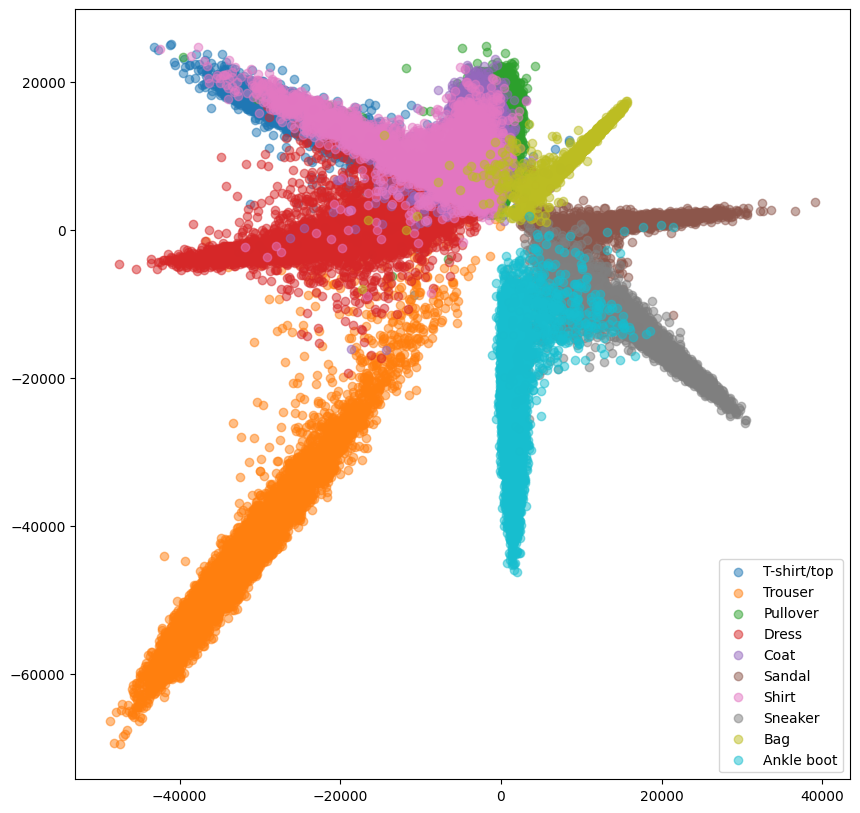

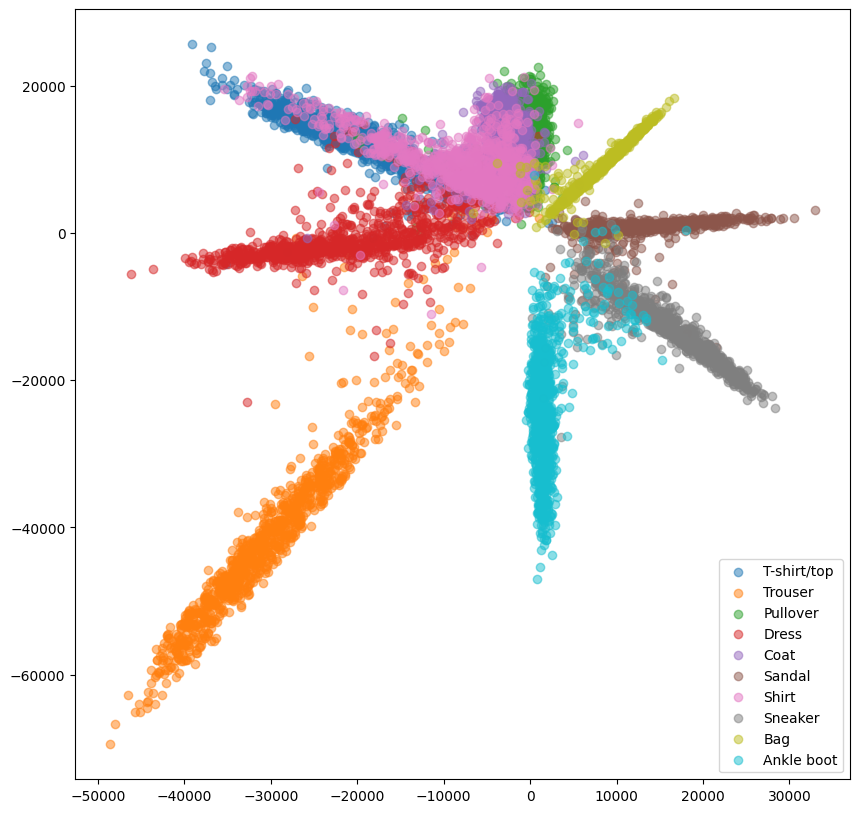

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Better Mining

<br>
<span style="color:blue">

**Exercise 1**: Explain the difference between semi-hard, easy and hard triplets. Try training with each type of triplets mentioned above separately and comment on the effect they have on training, using loss curves and other evidence you find necessary.
    
</span>

In [ ]:
#Your Code Here


<br>
<span style="color:blue">

**Exercise 2**: Read the documentation of the PyTorch Metric Learning library and try a couple of different mining strategies, distances, margins and loss functions.
    
</span>

In [ ]:
# Your Code Here


## Better embeddings

<br>
<span style="color:blue">

**Exercise 3**: Train a new (preferably more powerful) network with a 128-dimensional embedding, visualize the embedding using T-SNE.

We will use the T-SNE library from sklearn, you can see the [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for info on how to use it.

Report accuracies for both networks (the one with 2-dimensional embeddings and this one) and compare the visualizations of both embeddings.

Explanation of T-SNE [here](https://distill.pub/2016/misread-tsne/)

**Important T-SNE is rather slow so dont visualize the embeddings for every sample. Randomly select a few hundreds**

</span>

In [ ]:
# Your Code Here
